<a href="https://colab.research.google.com/github/Untick/NetOptik/blob/main/Mingaraev%20Ilsur/NetOptik_vgg16_418.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

              

---

              ОЗДАНИЕ МОДЕЛИ НЕЙРОСЕТИ ДЛЯ РАСПОЗНОВАНИЯ МАТЕРИАЛА ОПРАВЫ ОЧКОВ
---

### **Задача**



  Задача: разработка модели нейросети, которая сможет классифицировать очки по материалам - металл, пластик.

# Исходные данные

В качестве исходных данных служили два набора изображений очков, с металличекскими и пластиковыми оправами -https://drive.google.com/file/d/1-m9bjRA_NF5LWmUodDeMKWIwzcAPLjh2/view?usp=drive_link.
 Сами изображения были извлечены с сайта заказчика (https://www.netoptik.ru/) следуя ссылкам из предоставленного им файла (https://www.netoptik.ru/yandexmarket.yml).
Итоговый архив исходных изображений содержит по 918 изображений очков с каждым из исходных материалов.

# Выбор стратегии решения

  После многочисленных экспериментов с "классическим" построением модели "с нуля" (очень трудно получить результаты со степенью распознания больше 90%)
и попыток создания модели с помощью интструметария AutoKeras (в процессе обучения модели показывали высокий процент распознания, который позже не подтверждался на тестовых данных)
было решено  пойти по пути использования "классики", но в качестве исходной точки использовать модель, в процессе обучения которой были использованы (в том числе и) изображения очков
(https://image-net.org/challenges/LSVRC/2011/browse-synsets.php).

 В качестве такой модели была выбрана "открытая" модель vgg16 (https://neurohive.io/ru/vidy-nejrosetej/vgg16-model/)


# Подготовительные операции

### подключение библиотек

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

# Подключение библиотеки для загрузки изображений
from tensorflow.keras.preprocessing import image
# Подключение библиотеки для работы с массивами
import numpy as np
# Подключение библиотек для отрисовки изображений
import matplotlib.pyplot as plt
# Подключение модуля для работы с файлами
import os
# Вывод изображения в ноутбуке, а не в консоли или файле
%matplotlib inline

In [ ]:
from tensorflow.keras.models import Sequential                                                                 # абстрактный класс базовой модели сети от кераса
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Flatten  # слои(нормализации, регуляризации и т.д)
from tensorflow.keras.optimizers import Adam

from keras.applications import VGG16

###подключение Гугл-диска

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zipName = 'PlastIron.zip'
zipPath = '/content/drive/MyDrive/NetOptik/'+ zipName

Mounted at /content/drive


Ссылка на архив с 2-мя материалами: https://drive.google.com/file/d/1-m9bjRA_NF5LWmUodDeMKWIwzcAPLjh2/view?usp=drive_link

##загрузка архива исходных изображений

In [ ]:
import os
# загрузка датасета
!cp $zipPath .
if(not os.path.exists(zipName)):
  #TODO get archiv from git
  #gdown.download(
  print ("copy Materials archive into current dir")


###распаковка архива

In [ ]:
# распаковка архива  в подкаталог data
if(not os.path.exists("data")):
  !unzip -q $zipName -d data

Iron/grand-5696-c12m-s2-1 (3) - копия.jpg:  mismatching "local" filename (Iron/grand-5696-c12m-s2-1 (3) - ╨║╨╛╨┐╨╕╤П.jpg),
         continuing with "central" filename version
Plastic/la-stella-381-с2-s2-1 (1).jpg:  mismatching "local" filename (Plastic/la-stella-381-╤Б2-s2-1 (1).jpg),
         continuing with "central" filename version
Plastic/la-stella-381-с2-s2-2 (2).jpg:  mismatching "local" filename (Plastic/la-stella-381-╤Б2-s2-2 (2).jpg),
         continuing with "central" filename version
Plastic/la-stella-kids-mс01-10-c04-s2-1 (1).jpg:  mismatching "local" filename (Plastic/la-stella-kids-m╤Б01-10-c04-s2-1 (1).jpg),
         continuing with "central" filename version
Plastic/la-stella-kids-mс01-10-c04-s2-2 (2).jpg:  mismatching "local" filename (Plastic/la-stella-kids-m╤Б01-10-c04-s2-2 (2).jpg),
         continuing with "central" filename version
Plastic/la-stella-kids-mс01-810-c11-s2-1 (1).jpg:  mismatching "local" filename (Plastic/la-stella-kids-m╤Б01-810-c11-s2-1 (1).jpg),


2
#Сервисные функции

### Вывод размерностей тренировочного и тестового массивов


In [ ]:
def print_shapes():
  print ("Train shapes")
  print (x_train.shape)
  print (y_train.shape)

  print ("Test shapes")
  print (x_test.shape)
  print (y_test.shape)


### Отображение пар исходных изображений
на вход подается массив изображений, первая половина которого содержит изображения из одного материала, вторая - из другого
(по умолчанию выводится 5 пар)

In [ ]:
# отображение n пар
def showpairs( x_arr, n_rows =5, off =0):

  len = int(x_arr.shape[0]/2);
  if(n_rows > (len-off)):
     n_rows =  len-off;
  print ("\n")
  print (*labels, sep=" "*60)

  fig, axs = plt.subplots(n_rows,2, figsize=(12, 5*n_rows))
  axs = axs.flatten()
  # print(type(axs))
  for i in range(n_rows):
    j1 = i*2 #we draw 2 cells in each row
    axs[j1].axis('off')
    # print(i, indx)
    axs[j1].set_title(str(i+off))
    axs[j1].imshow(x_arr[ i+off])
    j2 = i+len+off
    # print(i, len,j)
    j1+=1 # next cell
    axs[j1].axis('off')
    axs[j1].set_title(str(j2))
    axs[j1].imshow( x_arr[j2])

  plt.show()


### Вывод графика хода обучения (визуализация history)

In [ ]:
# Рисование графиков
def paint_graph(history):
  import matplotlib.pyplot as plt
  fig_acc, axs = plt.subplots( 2, figsize=(8, 6))
  # axs = axs.flatten()
  # for i, ax in enumerate(axs):
    # if(0==i):
  axs[0].plot(history.history['accuracy'], label = 'Доля верных ответов на обучающей выборке')
  is_val = 'val_accuracy' in history.history
  if(is_val):
    axs[0].plot(history.history['val_accuracy'], label = 'Доля верных ответов на проверочном наборе')
  axs[0].set_xlabel('Эпоха обучения')
  axs[0].set_ylabel('Доля верных ответов')
  axs[0].legend()

    # else:
  axs[1].plot(history.history['loss'], label = 'Потери на обучающей выборке')
  is_loss = 'val_loss' in history.history
  if(is_loss):
    axs[1].plot(history.history['val_loss'], label = 'Потери на проверочном наборе')
  # axs.set_xlabel('Эпоха обучения')
      # axs.axis([0, 15, 0, 0.15])
  axs[1].set_xlabel('Эпоха обучения')
  axs[1].set_ylabel('Доля верных ответов')
  axs[1].legend()

  # выводим графики обучения
  plt.show()


### Вывод значений результатов предсказанных моделью
(результата делятся пополам - по количеству задействованных материалов - и выводятся в отдельных графиках
)


In [ ]:
# Рисование peзультатов
# def onpick(event):
#     artist = event.artist
#     if isinstance(artist, plt.Rectangle):
#         # im = artist
#         # A = im.get_array()
#         print('onpick ', event.xdata)


def show_predict(predict):
  import matplotlib.pyplot as plt
  fig_acc, axs = plt.subplots( 2, figsize=(6, 6))

  num = len(predict)//2
  iron  = list(predict[:num].reshape(-1))
  plast=  list(predict[num:].reshape(-1))
  indx =[]
  indx.extend(range(0,num))

  axs[0].bar(indx, plast )
  axs[0].set_title ('металл')

  axs[1].bar(indx, iron)
  axs[1].set_title ('пластик')

  # fig_acc.mpl_connect('pick_event')





## вывод крайних значений и сумм массва "передсказаний"


In [ ]:
def _sum(arr, start, end):
    sum = 0
    for i in range(start, end):
        sum += arr[i]
    return(sum)

def show_predict_vals(y_expect, N):
# печать крайних значений двух половин и их сумм
  print("металл  (д.б. 0-ли)", y_expect[0], y_expect[N-1], _sum(y_expect, 0, N))
  print("пластик (д.б. 1-цы)", y_expect[N], y_expect[-1],  _sum(y_expect, N, N*2))


### вывод Матрицы ошибок (confusion_matrix from sklearn)

In [ ]:

def showErrMatrix(predicted_y):
# Матрица ошибок классификатора
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  # Построение матрицы ошибок
  labels=("металл", "пластик")
  N = len(predicted_y)//2
  y_expect = np.zeros(N)                      # первая половина - нули
  y_expect = np.append(y_expect, np.ones(N))  # первая половина - единицы
  y_expect =list(y_expect)
  # вывести крайние значения и суммы диапазонов
  show_predict_vals(y_expect, N)

  cm = confusion_matrix(y_expect, np.rint(predicted_y))

      # Округление значений матрицы ошибок
      # cm = np.around(cm, cm_round)

  # Отрисовка матрицы ошибок
  fig, ax = plt.subplots(figsize=(20, 5))
  ax.set_title(f'матрица ошибок', fontsize=18)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(ax=ax)
  plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
  plt.xlabel('Предсказанные классы', fontsize=16)
  plt.ylabel('Верные классы', fontsize=16)
  fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
  plt.show()

  print('-'*100)

### функция "предсказать и показать"
- принимает на вход тестовый массив, выводятся оценочные графики predict-a модели

In [ ]:
def predict_and_show(test):
  predicted_y = model.predict(tf.expand_dims(test, -1))
  # print(predicted_y)

  show_predict( predicted_y )
  showErrMatrix(predicted_y )


### Сохранение модели
первоначально выполняется попытка сохранения полной модели в формате TensorFlow,
в случае неудачи - сохраняются весовые коэффициенты в 'h5' формате
 Сохраненная модель дублируется на Гугл-диске<br>
 Возвращается место сохранения модели (имя папки или файла в текщем/рабочем каталоге)

In [ ]:
from keras.src.saving.legacy.saving_utils import keras
def saveModel(model):
  if not 'best_path' in locals():
    best_path="model_wgg16"
  try:
      model.save(best_path, save_format="tf")
  except Exception:
      best_path += ".h5" #save to file only
      model.save(best_path)  # это точно - что запишется лучшая модель?

  # сохранение модель и на Гугл-диск
  !cp -r $save_place_type /content/drive/MyDrive/NetOptik/$best_path

  print("saved to:", best_path )
  return best_path

##Формирование модели на основе vgg16

In [ ]:
#целевая функция: максимум val_accuracy
#сама модель честно скопирована у Рубена

# # Загрузка модели VGG16 без весов ImageNet
# model = VGG16(weights=None, include_top=True)
def create_model(learn_rate = 1e-5):     # должна быть низкой, чтобы алгоритм обучения сошелся

  # Загружаем предварительно обученную нейронную сеть
  vgg16_net = VGG16(weights='imagenet',                         # признаки из набора данных "ImageNet"
                    include_top=False,                          # отключаем часть "классификация", оставляем только "сверточную часть"
                    input_shape=(img_height, img_width, 3))     # размер тензора входных изображений

  # "Замораживаем" веса предварительно обученной нейронной сети VGG16 (сверточную часть обучать не будем)
  vgg16_net.trainable = False

  model = Sequential()
  # Добавляем в модель сеть VGG16 вместо слоя
  model.add(vgg16_net)
  # Добавляем слои, для классификации
  model.add(Flatten())
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(learn_rate),
                metrics=['accuracy'])
  print("model is created")
  return model


##Подготовка callback функций


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.callbacks import EarlyStopping
def prepare_callback(model):
  best_path = saveModel(model)
  # Сохраняем только лучший вариант сети
  callbacks = [ModelCheckpoint(best_path, monitor='val_accuracy', save_best_only=True)
              # , EarlyStopping(monitor='val_accuracy', patience=5) # остановка если ухудшение после 5 шагов
              ]
  return callbacks


##[До]обучение модели
непосрественный вызов обученгия (fit) модели, по умолчанию = 50 эпох <br>
В случае, если история обучения успешно возвращена - выводится ее график



In [ ]:
def fit_model(epoxes=50):
  # prepare_callbacks()
  # Пробуем дообучить этку модель - с теми же параметрами, что применяли к модели автоКераса, но увеличим кол-во эпох
  history1 = model.fit(x_train, y_train, epochs=epoxes, batch_size=16, validation_split=0.2,verbose=1,
                      callbacks=callbacks,  shuffle =True)
  print("history from clf.fit:", history1)
  if(history1 != None):
    paint_graph(history1)
  rez =  max(history1.history['val_accuracy'])#[-1]
  print('last val_accuracy=', rez)
  return rez;

# Реализация


##инициализация рабочих массивов

In [ ]:
# Создание пустого списка для загрузки изображений обучающей выборки
x_train = []
# Создание списка для меток классов
y_train = []

x_test =[]
# Создание списка для меток классов
y_test = []

##считывание исходных изображений


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from numpy.core.multiarray import ndarray


# Путь к директории с базой
base_dir = '/content/data'

# Задание высоты и ширины загружаемых изображений
img_height = 160 #320
img_width  = 240 #480
# max_count = 50
labels =[]
# Преобразование в numpy-массив загруженных изображений и меток классов
# x_train = np.array(x_train)
# y_train = np.array(y_train)
# x_test = np.array(x_test)
# y_test = np.array(y_test)

# Перебор папок в директории базы
rez =0
for material in os.listdir(base_dir):
    labels.append(material)
    print (rez, material, labels)

    index=0
    # Перебор файлов в папках
    for img in os.listdir(base_dir + '/' + material):
        # Добавление в список изображений текущей картинки
        fname = base_dir + '/' + material + '/' + img
      # glass = image.img_to_array(image.load_img(base_dir + '/' + material + '/' + img,
        glass = image.img_to_array(image.load_img(fname,
                                                    target_size=(img_height, img_width)
                                                    ,color_mode='rgb'
                                                    # ,color_mode='grayscale'
                                                    ))
        x_train.append(glass)

        # Добавление в массив меток, соответствующих класса
        # y_train = np.append(y_train, material)
        y_train.append(rez) # material
        index+= 1
        if index > 417:
           break # минимальное кол-во из 2-х массивов
    rez+=1

# Вывод размерностей
#  print('Размер массива x_train', x_train.shape)
#  print('Размер массива y_train', y_train.shape)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test  = np.array(x_test)
y_test  = np.array(y_test)
print_shapes()


0 Iron ['Iron']
1 Plastic ['Iron', 'Plastic']
Train shapes
(836, 160, 240, 3)
(836,)
Test shapes
(0,)
(0,)


##нормализация данных изображений



Iron                                                            Plastic


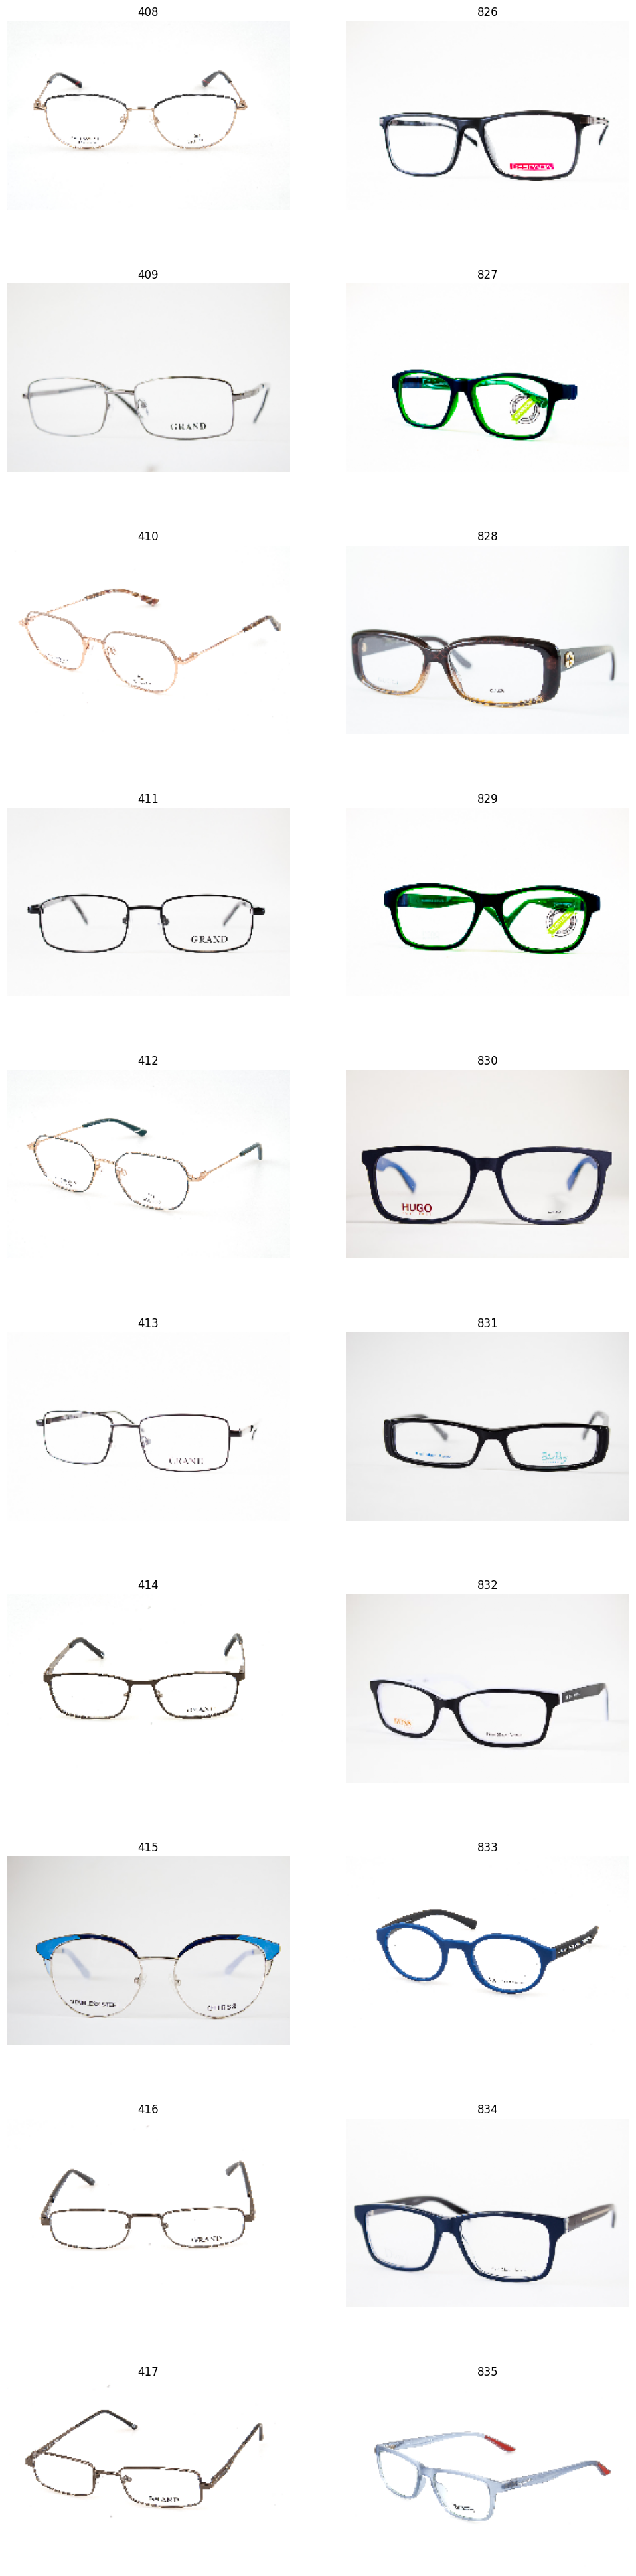

In [ ]:
#нормализация данных
x_train = x_train / 255.0
x_test  = x_test/ 255.0
showpairs(x_train,10, 418-10) #отображение последних 10 маделей

## Формирование проверочного массива данных
от тренировочного массива "откусываются" по 20 изображений в начале и конце - для каждого из материалов.<br>
 В итоге получаем 2 проверочных массива по 40 элементов каждый




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
befX (20, 160, 240, 3) (20, 160, 240, 3)
aftX (40, 160, 240, 3) (20, 160, 240, 3)
Train shapes
(816, 160, 240, 3)
(816,)
Test shapes
(40, 160, 240, 3)
(20,)
Train shapes
(796, 160, 240, 3)
(796,)
Test shapes
(40, 160, 240, 3)
(40,)


Iron                                                            Plastic


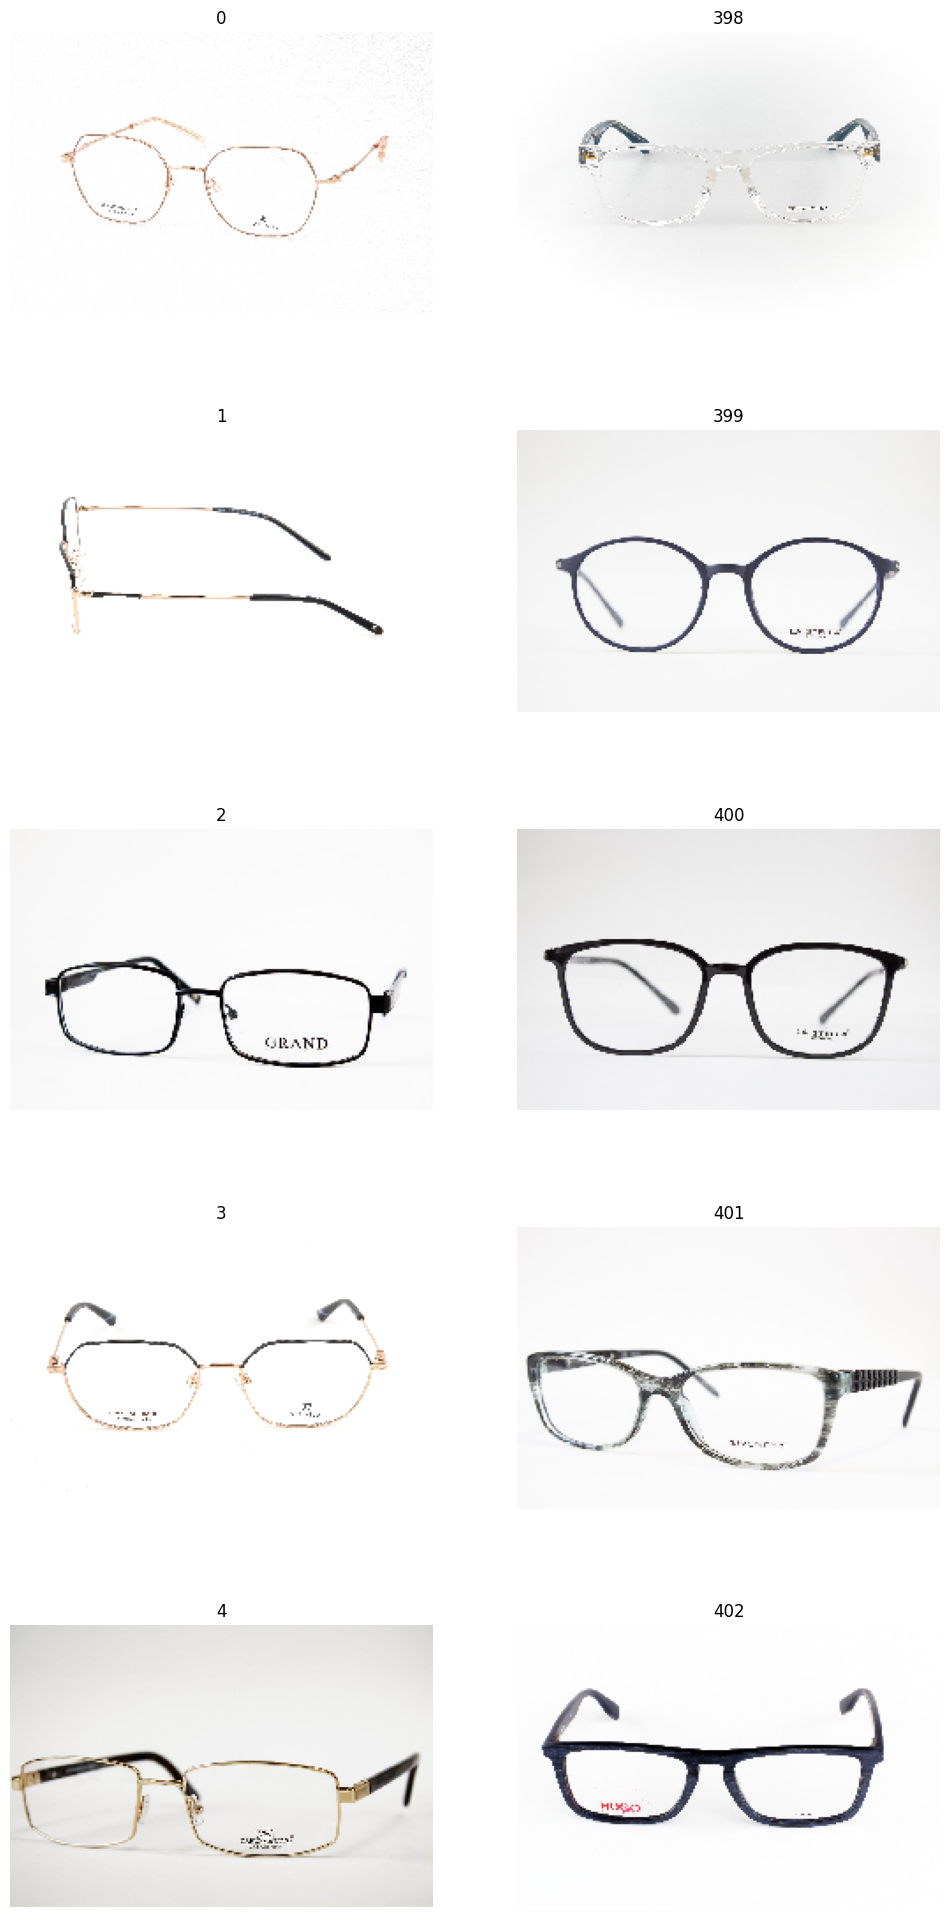



Iron                                                            Plastic


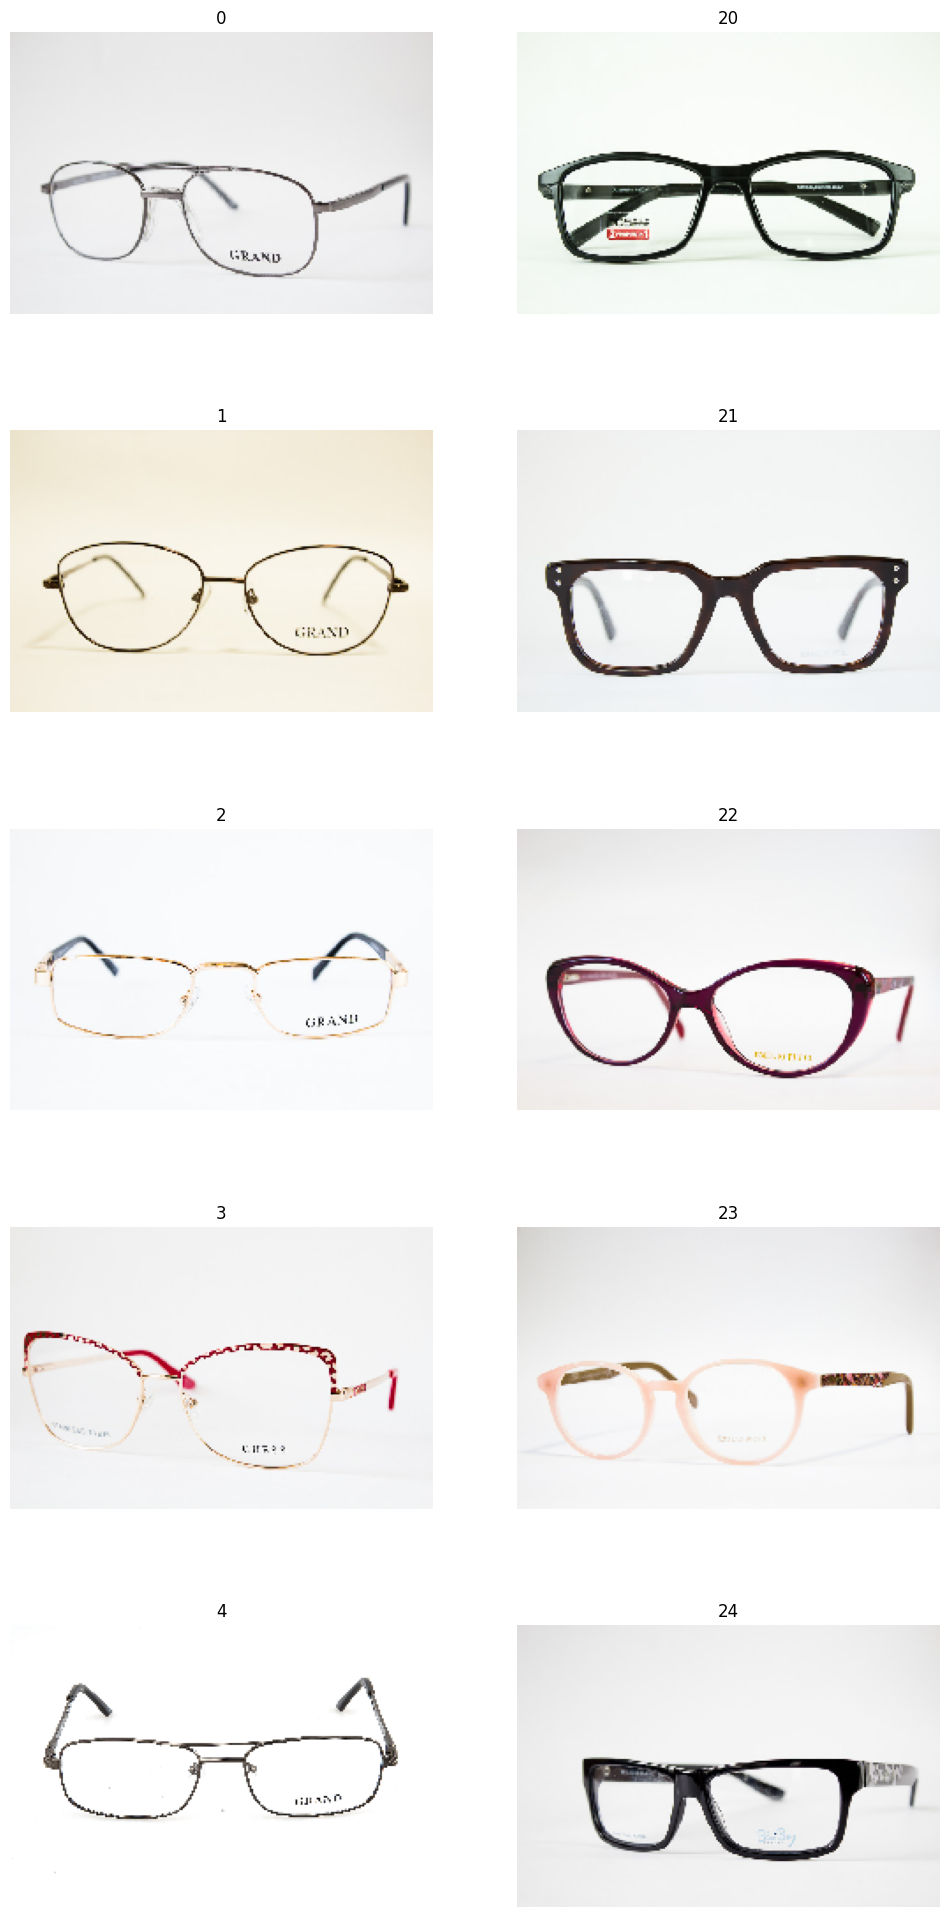

In [ ]:
# один из материалов - в начале
# print ( x_train.shape)
x_test  = x_train[:20]
x_train = x_train[20:]
# print ("first 20x", x_test.shape, x_train.shape)

y_test  = y_train[:20]
y_train = y_train[20:]
# print ("first 20y", y_train[0], y_test.shape, y_train.shape)

# другой материал - в конце
print (type(x_test))
xTemp = x_train[-20:]
print (type(xTemp))
print("befX",x_test.shape, xTemp.shape)
#x_test  = np.append(x_test, x_train[-20:])
x_test  = np.append(x_test, xTemp, axis=0)
# x_test  = x_test+xTemp
print("aftX", x_test.shape, xTemp.shape)
print_shapes()
x_train = x_train[0:-20]

# y_test += y_train[-20:].astype(str)  #?????? ufunc 'add' did not contain a loop with signature matching types (dtype('<U7'), dtype('<U7')) -> None
y_test = np.append(y_test, y_train[-20:] )
y_train = y_train[0:-20]

# показать тестовые пары
print_shapes()
showpairs( x_train)
showpairs( x_test)

In [ ]:
y_train = y_train.reshape((-1,1))
y_test  = y_test.reshape((-1,1))
print_shapes()
#showpairs(x_train) #after normalization
print(y_test)

Train shapes
(796, 160, 240, 3)
(796, 1)
Test shapes
(40, 160, 240, 3)
(40, 1)
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


##Инициализация модели


In [ ]:
#  если уже существует некая "лучшая" модель - грузим ее,  иначе строим на основе wgg16

# if not 'best_path' in locals():
#     best_path="model_wgg16"

# if os.path.exists(best_path):
#   model = load_model(best_path)
#   print("model is loaded")
# else:
model = create_model()


model is created


In [ ]:
 # Вывод архитектуры
model.summary()
print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 17920)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               4587776   
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
 activation_3 (Activation)   (None, 1)                

##Проверка "сходу"

Train shapes
(796, 160, 240, 3)
(796, 1)
Test shapes
(40, 160, 240, 3)
(40, 1)
2/2 [==============================] - 12s 1s/step
металл  (д.б. 0-ли) 0.0 0.0 0.0
пластик (д.б. 1-цы) 1.0 1.0 20.0


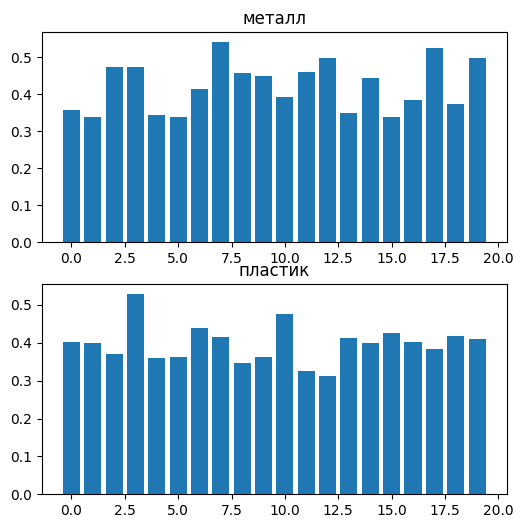

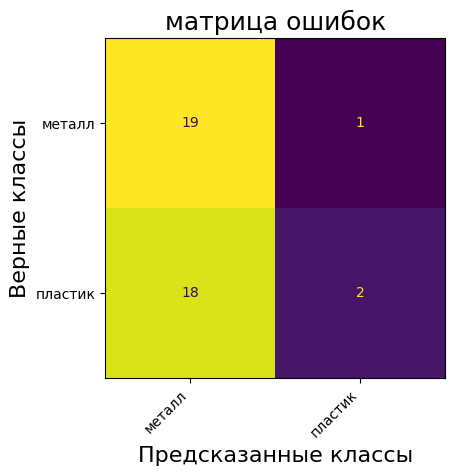

----------------------------------------------------------------------------------------------------


In [ ]:
# показать тестовые пары
print_shapes()
# Пробуем предсказать "сразу"
predict_and_show(x_test)


In [ ]:
# Матрица ошибок - показывает, что практически все модели металлические!
# - пользоваться такой моделью (без дообучения) - нельзя!

##  обучение

cp: missing destination file operand after '/content/drive/MyDrive/NetOptik/'
Try 'cp --help' for more information.
saved to: model_wgg16
Epoch 1/50
40/40 [==============================] - 11s 175ms/step - loss: 0.5480 - accuracy: 0.7091 - val_loss: 0.5024 - val_accuracy: 0.7812
Epoch 2/50
40/40 [==============================] - 5s 121ms/step - loss: 0.3408 - accuracy: 0.8774 - val_loss: 0.4123 - val_accuracy: 0.8188
Epoch 3/50
40/40 [==============================] - 7s 169ms/step - loss: 0.2545 - accuracy: 0.9072 - val_loss: 0.3040 - val_accuracy: 0.9062
Epoch 4/50
40/40 [==============================] - 5s 118ms/step - loss: 0.1949 - accuracy: 0.9371 - val_loss: 0.2211 - val_accuracy: 0.9375
Epoch 5/50
40/40 [==============================] - 3s 65ms/step - loss: 0.1638 - accuracy: 0.9481 - val_loss: 0.2489 - val_accuracy: 0.9000
Epoch 6/50
40/40 [==============================] - 6s 147ms/step - loss: 0.1409 - accuracy: 0.9528 - val_loss: 0.1514 - val_accuracy: 0.9625
Epoch 7/50

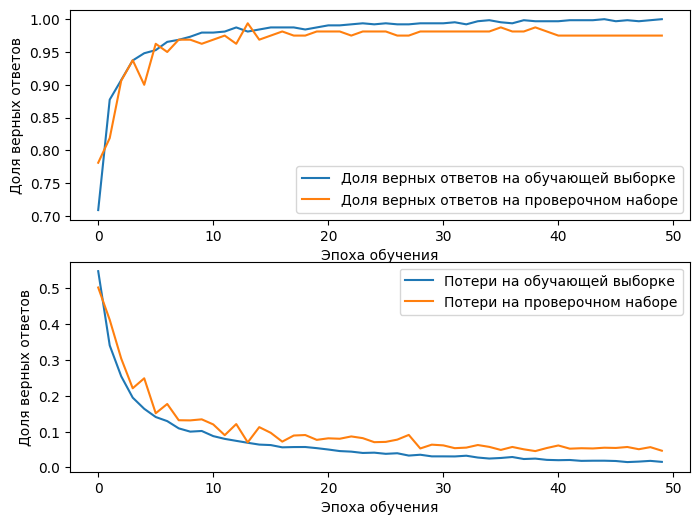

last val_accuracy= 0.9937499761581421


0.9937499761581421

In [ ]:
callbacks = prepare_callback(model)
#[до]обучаем модель
fit_model()

cp: missing destination file operand after '/content/drive/MyDrive/NetOptik/'
Try 'cp --help' for more information.
saved to: model_wgg16
Epoch 1/30
40/40 [==============================] - 5s 78ms/step - loss: 0.0152 - accuracy: 0.9984 - val_loss: 0.0449 - val_accuracy: 0.9750
Epoch 2/30
40/40 [==============================] - 3s 69ms/step - loss: 0.0169 - accuracy: 0.9984 - val_loss: 0.0370 - val_accuracy: 0.9812
Epoch 3/30
40/40 [==============================] - 3s 69ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.0498 - val_accuracy: 0.9750
Epoch 4/30
40/40 [==============================] - 3s 67ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0418 - val_accuracy: 0.9812
Epoch 5/30
40/40 [==============================] - 3s 68ms/step - loss: 0.0160 - accuracy: 0.9953 - val_loss: 0.0486 - val_accuracy: 0.9750
Epoch 6/30
40/40 [==============================] - 3s 72ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.0498 - val_accuracy: 0.9750
Epoch 7/30
40/40

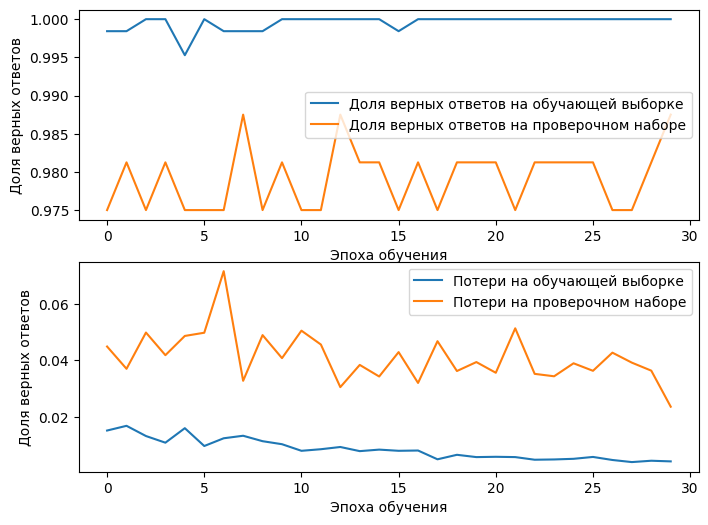

last val_accuracy= 0.987500011920929
Epoch 1/30
40/40 [==============================] - 5s 77ms/step - loss: 0.0181 - accuracy: 0.9969 - val_loss: 0.0487 - val_accuracy: 0.9750
Epoch 2/30
40/40 [==============================] - 3s 71ms/step - loss: 0.0156 - accuracy: 0.9984 - val_loss: 0.0498 - val_accuracy: 0.9750
Epoch 3/30
40/40 [==============================] - 3s 73ms/step - loss: 0.0152 - accuracy: 0.9984 - val_loss: 0.0463 - val_accuracy: 0.9750
Epoch 4/30
40/40 [==============================] - 3s 71ms/step - loss: 0.0129 - accuracy: 0.9984 - val_loss: 0.0503 - val_accuracy: 0.9750
Epoch 5/30
40/40 [==============================] - 4s 94ms/step - loss: 0.0136 - accuracy: 0.9969 - val_loss: 0.0497 - val_accuracy: 0.9750
Epoch 6/30
40/40 [==============================] - 3s 72ms/step - loss: 0.0132 - accuracy: 0.9984 - val_loss: 0.0551 - val_accuracy: 0.9750
Epoch 7/30
40/40 [==============================] - 3s 73ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0391

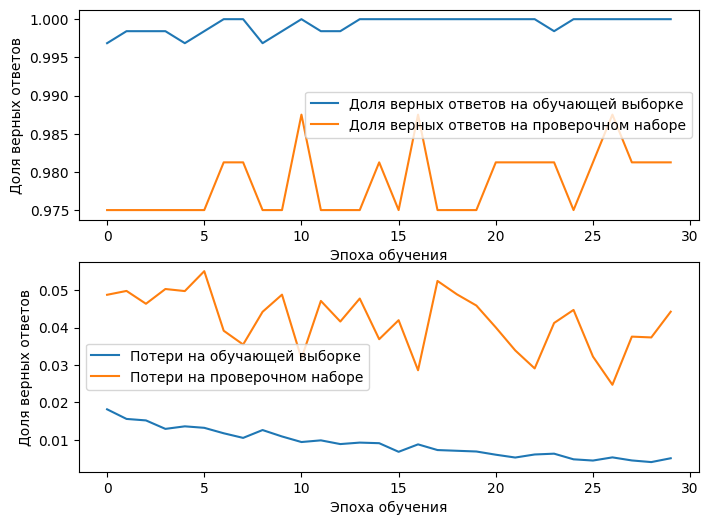

last val_accuracy= 0.987500011920929
Epoch 1/30
40/40 [==============================] - 5s 83ms/step - loss: 0.0165 - accuracy: 0.9969 - val_loss: 0.0518 - val_accuracy: 0.9750
Epoch 2/30
40/40 [==============================] - 3s 70ms/step - loss: 0.0158 - accuracy: 0.9984 - val_loss: 0.0539 - val_accuracy: 0.9750
Epoch 3/30
40/40 [==============================] - 3s 72ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9750
Epoch 4/30
40/40 [==============================] - 3s 69ms/step - loss: 0.0173 - accuracy: 0.9984 - val_loss: 0.0422 - val_accuracy: 0.9812
Epoch 5/30
40/40 [==============================] - 3s 71ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.0609 - val_accuracy: 0.9750
Epoch 6/30
40/40 [==============================] - 3s 67ms/step - loss: 0.0135 - accuracy: 0.9969 - val_loss: 0.0380 - val_accuracy: 0.9812
Epoch 7/30
40/40 [==============================] - 3s 71ms/step - loss: 0.0140 - accuracy: 0.9969 - val_loss: 0.0391

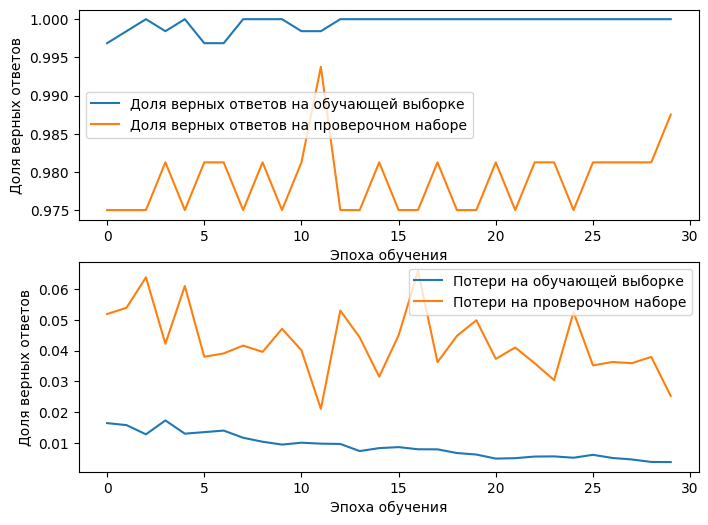

last val_accuracy= 0.9937499761581421
Epoch 1/30
40/40 [==============================] - 5s 86ms/step - loss: 0.0144 - accuracy: 0.9984 - val_loss: 0.0539 - val_accuracy: 0.9750
Epoch 2/30
40/40 [==============================] - 3s 70ms/step - loss: 0.0165 - accuracy: 0.9984 - val_loss: 0.0392 - val_accuracy: 0.9812
Epoch 3/30
40/40 [==============================] - 3s 66ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.0675 - val_accuracy: 0.9750
Epoch 4/30
40/40 [==============================] - 3s 67ms/step - loss: 0.0149 - accuracy: 0.9969 - val_loss: 0.0718 - val_accuracy: 0.9750
Epoch 5/30
40/40 [==============================] - 3s 67ms/step - loss: 0.0166 - accuracy: 0.9969 - val_loss: 0.0464 - val_accuracy: 0.9750
Epoch 6/30
40/40 [==============================] - 3s 73ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0348 - val_accuracy: 0.9875
Epoch 7/30
40/40 [==============================] - 3s 67ms/step - loss: 0.0114 - accuracy: 0.9984 - val_loss: 0.054

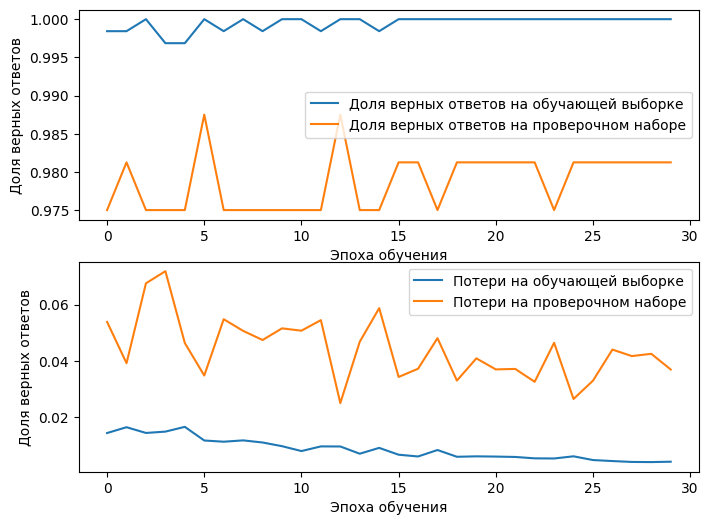

last val_accuracy= 0.987500011920929
Epoch 1/30
40/40 [==============================] - 4s 77ms/step - loss: 0.0194 - accuracy: 0.9937 - val_loss: 0.0745 - val_accuracy: 0.9750
Epoch 2/30
40/40 [==============================] - 3s 71ms/step - loss: 0.0171 - accuracy: 0.9969 - val_loss: 0.0605 - val_accuracy: 0.9750
Epoch 3/30
40/40 [==============================] - 3s 68ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.0347 - val_accuracy: 0.9875
Epoch 4/30
40/40 [==============================] - 3s 72ms/step - loss: 0.0150 - accuracy: 0.9984 - val_loss: 0.0436 - val_accuracy: 0.9750
Epoch 5/30
40/40 [==============================] - 3s 70ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.0357 - val_accuracy: 0.9875
Epoch 6/30
40/40 [==============================] - 3s 70ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.0646 - val_accuracy: 0.9750
Epoch 7/30
40/40 [==============================] - 3s 74ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0283

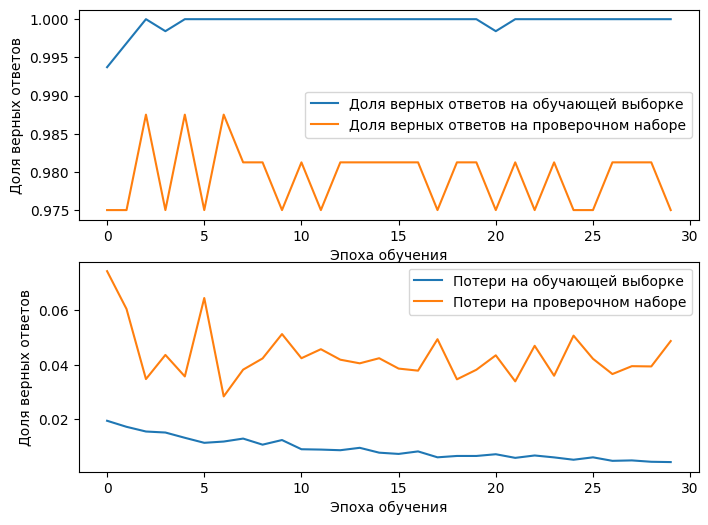

last val_accuracy= 0.987500011920929


In [ ]:
# очень красивые графики. и судя по ним  (линии еще не горизонтальны)- у модели еще есть потенциал
# на 14-й эпохе модельт выдала 0.9937 (сегодня shufle "разложил карты" более удачно)
# Попытаемся "выжать" из нее "еще немного процентов"  (но ограничимся при этом 5 попытками по 30 эпок)

if not 'best_path' in locals(): # модель  еще не подгружалассь с диска и не сохранялась
    best_path = saveModel(model)

# callbacks = [ModelCheckpoint(best_path, monitor='val_accuracy', save_best_only=True)]
attempt =0
rez =0
while(rez <0.995 and attempt <5):
  # print("attempt", attempt)
  model = load_model(best_path)
  rez =fit_model(30)

  attempt+=1


Дополнительные 150 эпох практически не улучшили результата.
 Несмотря на то, что на некотрых попытках удавалось повторить результат первого обучения (0.9937) функция поиска всегда сваливалась вниз.
  Налицо также явные "ограничения" (горизонтальные полки) - не выпускающие линию поиска вверх. Это (и повторяемость результатов на полках) позволяет предположить, что моделье может "вырваться из локальных минимумов (явно обозначенных и повторяющихся на уровнях 0.975, 0.9812, 0.975б 0,9875)
  На предыдущих поисках для этой же модели эти горизонтальные уровни наблюдались также  на значениях  0.9659 и 0.9886  
Это позволяет предположить следующее:
0. Результаты запуска ноутбука сродни рыбалке - "либо клюнет, либо - нет".
(видимо все зависит от используемой среды и результатов перемешивания данных)
1. Есть большие сомнения в корректности работы механизма callback-ов.
 - Судя по графикам, функция fit не всегда  стартует с коеффициентов,  присущих "лучшей" модели предыдущего поиска- практически все "попытки" стартоаали с уровня 0.975 (при ранее достигнутом "лучшем" уровне 0.9937)
[Декаду назад "стартовый" уровень был на уровне<u> 0.992 </u>(см. историю от 18.09]
2. Используемая модель по умолчанию использует очень мелкий шаг обучения
 (1.е-05), что, по видимому, не озволяет ей "вырваться" из обнаруженных локальных минимумов

model is created
Epoch 1/150
40/40 [==============================] - 5s 75ms/step - loss: 1.4493 - accuracy: 0.8616 - val_loss: 0.0133 - val_accuracy: 0.9937
Epoch 2/150
40/40 [==============================] - 3s 65ms/step - loss: 0.3254 - accuracy: 0.9497 - val_loss: 0.2111 - val_accuracy: 0.9438
Epoch 3/150
40/40 [==============================] - 3s 64ms/step - loss: 0.2401 - accuracy: 0.9481 - val_loss: 0.0089 - val_accuracy: 0.9937
Epoch 4/150
40/40 [==============================] - 3s 67ms/step - loss: 0.0640 - accuracy: 0.9717 - val_loss: 0.1092 - val_accuracy: 0.9625
Epoch 5/150
40/40 [==============================] - 3s 66ms/step - loss: 0.0626 - accuracy: 0.9796 - val_loss: 0.0642 - val_accuracy: 0.9750
Epoch 6/150
40/40 [==============================] - 3s 65ms/step - loss: 0.0521 - accuracy: 0.9827 - val_loss: 0.1025 - val_accuracy: 0.9563
Epoch 7/150
40/40 [==============================] - 3s 69ms/step - loss: 0.0397 - accuracy: 0.9858 - val_loss: 0.0456 - val_accura

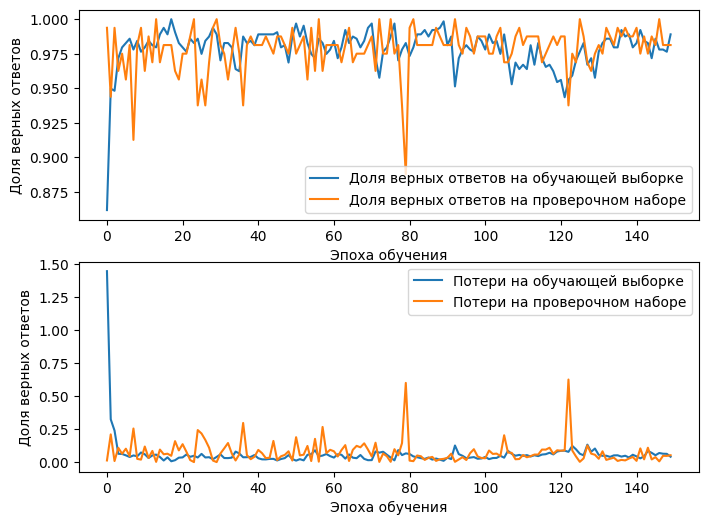

last val_accuracy= 1.0


1.0

In [ ]:
# Проверим гипотезу о "бесполезности нескольких запусков подряд" (или неумении сохранять/загружать "лучшие модели")
#  - запустим обучение на те же 150 эпох, но подряд! (заодно выясним и справедливость вывода "#1")
# пересоздаем ту же модель заново - никаких "лучших"  и зададим ей больший шаг обученияи- для проверки пункта №2
model = create_model( 0.005)
fit_model(150)


 Получив большую свободу движения,  модель выдала "100%" результат уже на 14 эпохе, более того, э о результат повторялся еще 9 раз
  
   Проведем процедуры проверки полученной модели (в надежде, что она таки сохранила свои лучшие, "стопроцеентные" коеффициенты - на заранее выделенных тестовых данных (тех же, на которых проверялась модель перед дообучением)


 ##проверка достигнутых результатов обучения

model_wgg16
Train shapes
(796, 160, 240, 3)
(796, 1)
Test shapes
(40, 160, 240, 3)
(40, 1)
2/2 [==============================] - 0s 114ms/step
металл  (д.б. 0-ли) 0.0 0.0 0.0
пластик (д.б. 1-цы) 1.0 1.0 20.0


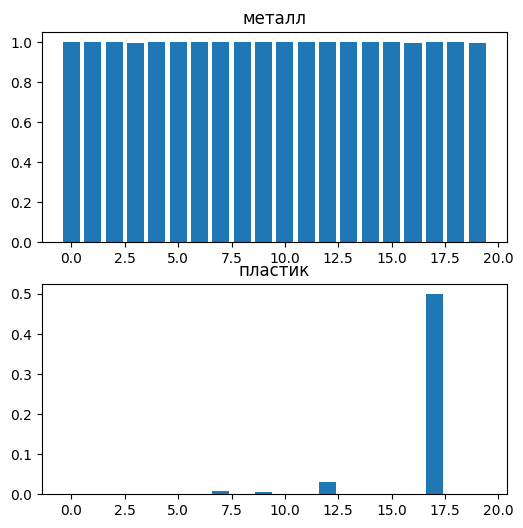

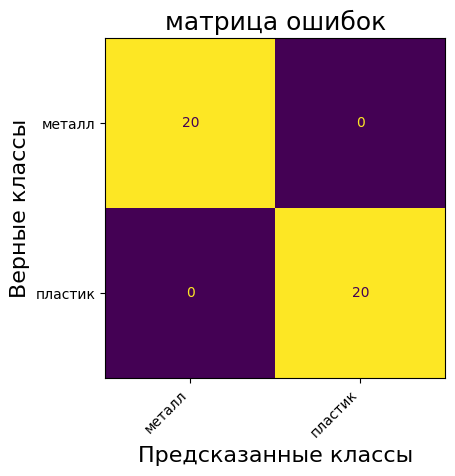

----------------------------------------------------------------------------------------------------


In [ ]:
print(best_path)
model = load_model(best_path)
 # сохранение модель и на Гугл-диск
!cp -r $best_path /content/drive/MyDrive/NetOptik/30_09/$best_path
print_shapes()
predict_and_show(x_test)

 Модель ошибок (округляющая результаты до единицы) действительно выдает 100%-но хороший результат, хотя на предыдущем графике видно, что одна из пластиковах моделей (№17) была "на грани провала".


# Проверка модели на тестовых данных
В качестве контрольных тестов
 использовались "незнакомые для модели данные", более того, это - "несуществующие изображения": в качестве проверочных изображений использовались результаты аугментации(сгенерированные стажером Рубеном Брутяном). <br>
 В этом наборе содержится 108 изображений - по 54 для металла и пластика.

##Загрузка и распаковка архива тестовых данных

In [ ]:
!rm -r -f /content/test_data/
#загрузка реально тестовых данных

zipName = 'test-54.zip'
zipPath = '/content/drive/MyDrive/NetOptik/'+ zipName

# загрузка датасета
!cp $zipPath .
if(not os.path.exists(zipName)):
  #TODO get archiv from git
  #gdown.download(
  print ("copy test Materials archive into current dir")
# распаковка архива  в подкаталог data
if(not os.path.exists("test_data")):
  !unzip -q $zipName -d test_data



##инициализация изображений

In [ ]:
# Путь к директории с базой
base_dir = 'test_data'

# Задание высоты и ширины загружаемых изображений
img_height = 160 #320
img_width  = 240 #480

x_test=[]
labels=[]
# Перебор папок в директории базы
for material in os.listdir(base_dir):
    labels.append(material)
    # Перебор файлов в папках
    counter =0
    for img in os.listdir(base_dir + '/' + material):
        # Добавление в список изображений текущей картинки
        glass = image.img_to_array(image.load_img(base_dir + '/' + material + '/' + img,
                                                    target_size=(img_height, img_width)
                                                    ,color_mode='rgb'
                                                    # ,color_mode='grayscale'
                                                    ))
        x_test.append(glass)


x_test  = np.array(x_test)
# Вывод размерностей
print('Размер массива x_test', x_test.shape)



Размер массива x_test (108, 160, 240, 3)


##нормализация данных



iron54                                                            plast54


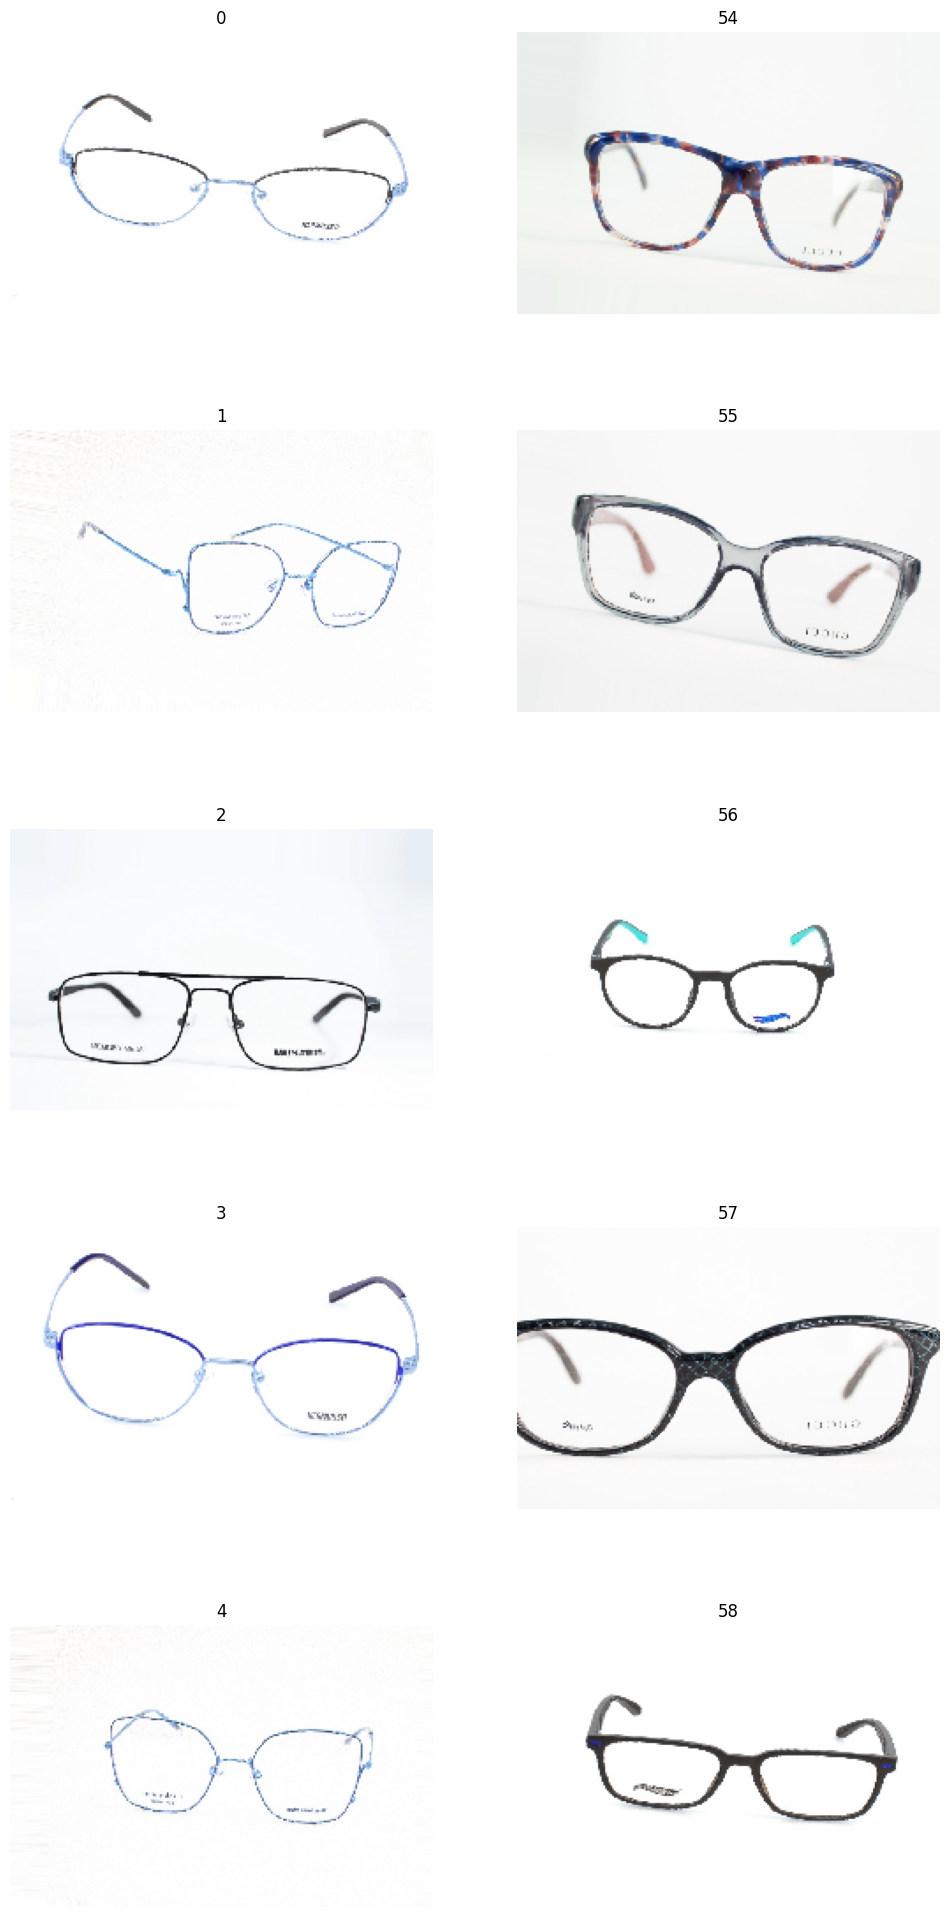

In [ ]:
x_test = x_test/ 255.0
#print(x_test.shape[0]/2)
#print( int(x_test.shape[0]/2+0.00001))

showpairs( x_test)

##непосредственно проверка модели на тестовых данных

4/4 [==============================] - 0s 103ms/step
металл  (д.б. 0-ли) 0.0 0.0 0.0
пластик (д.б. 1-цы) 1.0 1.0 54.0


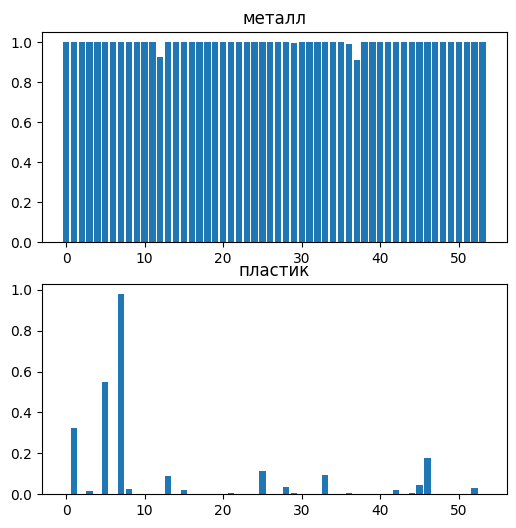

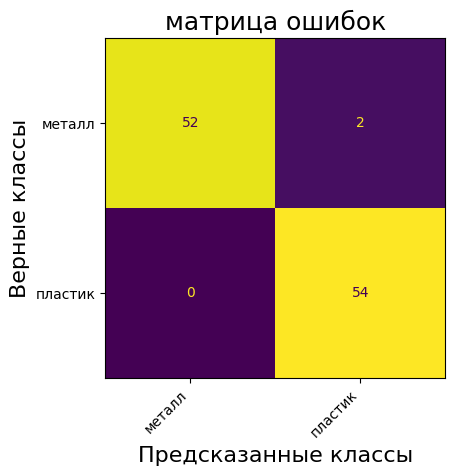

----------------------------------------------------------------------------------------------------


In [ ]:
predict_and_show(x_test)

Только 2 не верных ответа из 108! (Точность - на уровне 0.98)

Проверим ее же еще раз, но уже на данных обучения

##проверка модели на массиве обучения

25/25 [==============================] - 6s 228ms/step
металл  (д.б. 0-ли) 0.0 0.0 0.0
пластик (д.б. 1-цы) 1.0 1.0 398.0


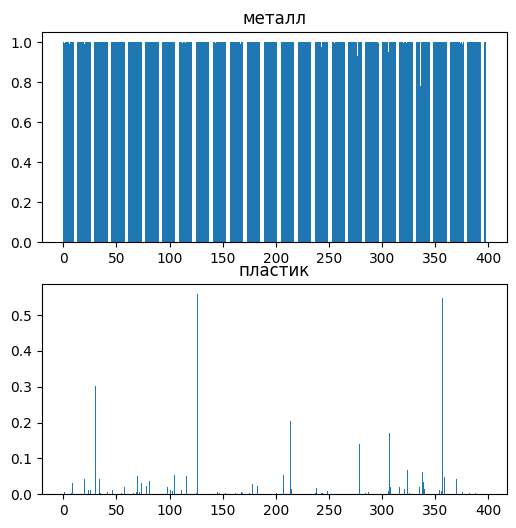

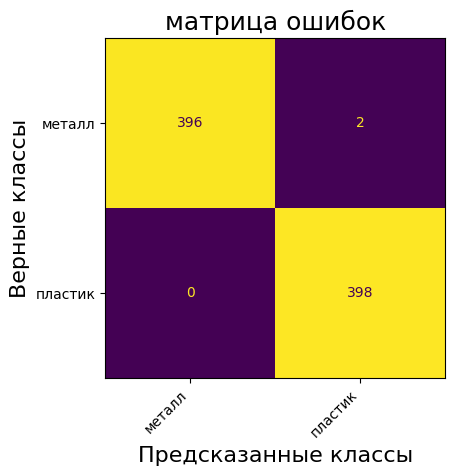

----------------------------------------------------------------------------------------------------


In [ ]:
predict_and_show(x_train)

На "знакомых" данных результат ожидаемо лучше (те же 2 ошибки на пластике,
 но уже из 796 изображений), суммарная точность ~ 0.998 (Все-таки - не 100%!)


# Вывод

На основе предложенных заказчиком данных была обучена (точнее дообучена - поскольку, в качестве исходной была принята модель wgg16) модель, способная  классифицировать материал (пластик или металл) на "незнакомых" тестовых данных с точностью 98 %.
 Модель распологается по адресу: https://drive.google.com/drive/folders/1oDL4UF3ldN-sCPIdyG7dbXwQKHwC5Tut?usp=sharing